In [ ]:
!pip install cubist
!pip install kmodes
!pip install ucimlrepo
!pip install ipdb
!pip install scikeras
!pip install --upgrade kneed
!pip3 install tabulate
from ucimlrepo import fetch_ucirepo
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from cubist import Cubist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from keras.models import Sequential
from kmodes.kprototypes import KPrototypes
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from scipy import stats
from kneed import KneeLocator
from sklearn import preprocessing
from tabulate import tabulate
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import ipdb;ipdb
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import json
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.0/582.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible

In [ ]:
# Import the datset
seoul_bike_sharing_demand = fetch_ucirepo(id=560)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets
bike_df = pd.concat([X, y], axis=1)

# Display the first 5 rows of the dataset
print(bike_df.head(5))

        Date  Rented Bike Count  Hour  Temperature  Humidity  Wind speed  \
0  1/12/2017                254     0         -5.2        37         2.2   
1  1/12/2017                204     1         -5.5        38         0.8   
2  1/12/2017                173     2         -6.0        39         1.0   
3  1/12/2017                107     3         -6.2        40         0.9   
4  1/12/2017                 78     4         -6.0        36         2.3   

   Visibility  Dew point temperature  Solar Radiation  Rainfall  Snowfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

  Seasons     Holiday Functioning Day  
0  Winter  No Holiday             Yes  


## Feature Engineering

Same as clustering analysis, feature engineering is performed to improve the performance of the regression models. The original date feature was separated into 5 meaningful temporal features below


*   Day (int64): A specific day of a month that
*   Month (object): A specific month that the data was collected
*   Year (int64): A year that the data was collected
*   Day of the week (object): Day of the week (e.g., Monday, Tuesday)
*   Week status (object): Whether the day was in weekday/ weekend

This is in attempt to extract useful, stable and consistent temporal information from the 'Date' feature, and help the models to identify useful temporal patterns that are generalizable to the test set.


In [ ]:
Bike_df_regression = bike_df.copy()

Bike_df_regression['Date'] = pd.to_datetime(bike_df['Date'], format='%d/%m/%Y')

# Separate Day, Month (abbreviation), and Year from 'Date'
Bike_df_regression['Day'] = Bike_df_regression['Date'].dt.day
Bike_df_regression['Year'] = Bike_df_regression['Date'].dt.year
Bike_df_regression['Month'] = Bike_df_regression['Date'].dt.month

# Extract Day of the Week (0 = Monday, 6 = Sunday) from date
Bike_df_regression['Day of the week'] = Bike_df_regression['Date'].dt.dayofweek
# Create new columns for week status (weekday/weekend) and day of the week (Monday to Sunday) categories
Bike_df_regression['Week status'] = Bike_df_regression['Day of the week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
Bike_df_regression['Day of the week'] = Bike_df_regression['Date'].dt.day_name()

In [ ]:
#drop columns that are not needed for regression
drop_col = ['Dew point temperature', 'Date']
Bike_df_regression = Bike_df_regression.drop(drop_col, axis=1)

Bike_df_encoded_data = pd.get_dummies(Bike_df_regression, columns = ['Seasons', 'Holiday', 'Functioning Day', 'Day of the week', 'Week status'], dtype=float)

In [ ]:
# Define a random seed for reproducibility
random_seed = 42

#Define the independent variables (X) and depentent (target) varibale (y)
X = Bike_df_encoded_data.loc[:, Bike_df_encoded_data.columns!='Rented Bike Count']
y = Bike_df_encoded_data['Rented Bike Count']
#Split the dataste into a 75% training set and a 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= random_seed)

In [ ]:
# This function is used to store the results of grid search so later we can
# creat plots from these results
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    else:
        return obj

## Gradient Boosting Machine

In [ ]:
# Use grid search to find the best hyperparamters for GMB

# Initialize GBM
model = GradientBoostingRegressor(random_state=random_seed)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': list(range(20, 520, 20)),  # n_estimators from 20 to 500
    'max_depth': list(range(1, 17, 2))       # max_depth from 1 to 15
}

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV on validation sets for hyperparameter tuning with R-squared as the scoring metric
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=4, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of GBM:", grid_result.best_params_)

# Best hyperparameters of CUBIST: 'max_depth': 7, 'n_estimators': 500

with open('GBM.json', 'w') as file:
    json.dump(convert_to_serializable(grid_result.cv_results_), file)

Fitting 30 folds for each of 4 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters of GBM: {'max_depth': 7, 'n_estimators': 40}


The best hyperparameters of GBM after feature engineering are {'max_depth': 7, 'n_estimators': 500}. To better visualize the results of grid search, a plot for the performance of each hyperparameter combination is created. The performance of the best model is summarized in the following code blocks.

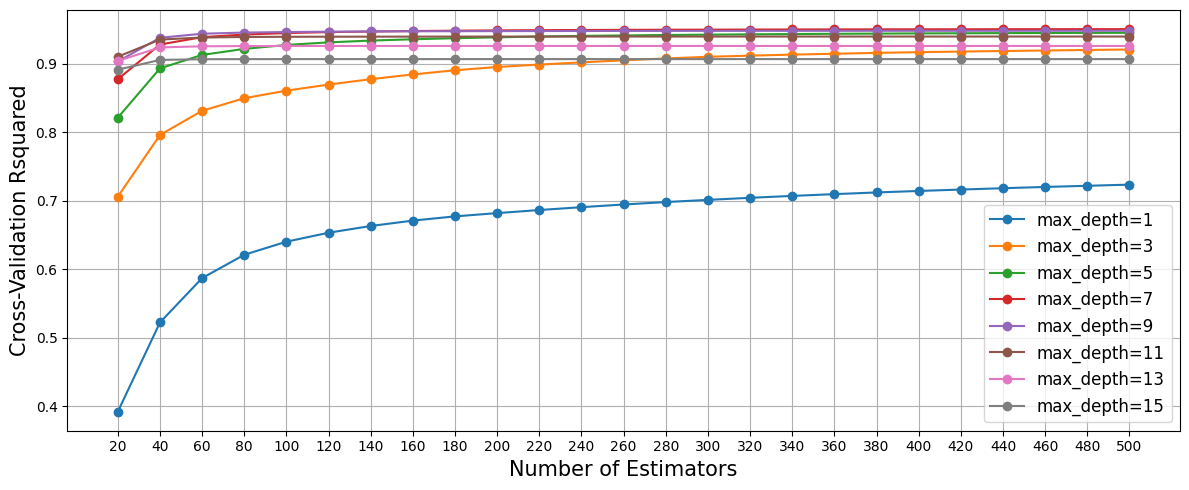

In [ ]:
gbm_local_grid_search_path = 'GBM.json'

# Read the JSON file
with open(gbm_local_grid_search_path, 'r') as file:
    gbm_gs = json.load(file)

# Convert the data into a DataFrame
gbm_gs_df = pd.DataFrame(gbm_gs['params'])
gbm_gs_df['y'] = gbm_gs['mean_test_score']

# One line per max depth
plt.figure(figsize=(12, 5))
for max_depth in gbm_gs_df['max_depth'].unique():
    subset = gbm_gs_df[gbm_gs_df['max_depth'] == max_depth]
    plt.plot(subset['n_estimators'], subset['y'], marker='o', label=f'max_depth={max_depth}')

# labels
plt.xlabel('Number of Estimators', fontsize=15)
plt.ylabel("Cross-Validation Rsquared", fontsize=15)
plt.legend(title='', fontsize=12)
plt.grid(True)

# x-axis only has integer values
plt.xticks(
    range(
        gbm_gs_df['n_estimators'].min(),
        gbm_gs_df['n_estimators'].max() + 1,
        20
    )
)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Initialize GBM with tuned hyperparameters
GBM_tuned = GradientBoostingRegressor(n_estimators=500, max_depth=7, random_state=random_seed)

# Train the tuned GBM on the training set
start_time = time.time()
GBM_tuned.fit(X_train, y_train)
end_time = time.time()
GBM_training_time = end_time - start_time

# Predict on the test set
GBM_tuned_pred = GBM_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
GBM_tuned_r2 = r2_score(y_test, GBM_tuned_pred)
GBM_tuned_mse = mean_squared_error(y_test, GBM_tuned_pred)
GBM_tuned_mae = mean_absolute_error(y_test, GBM_tuned_pred)


# Display the result of the r2 socre
print(f"R-squared score of tuned GBM on test set: {GBM_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned GBM on test set: {GBM_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned GBM on test set: {GBM_tuned_mae:.4f}")
print(f"Training time of GBM: {GBM_training_time} seconds")

R-squared score of tuned GBM on test set: 0.9469
Mean Squared Error (MSE) of tuned GBM on test set: 21741.7403
Mean Absolute Error (MAE) of tuned GBM on test set: 80.9491
Training time of GBM: 15.01012635231018 seconds


## CUBIST

In [ ]:
# Use grid search on the training set to the best hyperparameters for CUBIST

# hyperparameter grid to search over
n_committees_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
neighbors_list = [1, 3, 5, 7]

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize variables to store the best parameters and the best score
best_score = -np.inf
best_params = {}

# Grid search
all_params = []
all_scores = []
for n_committees in n_committees_list:
    for neighbors in neighbors_list:
        print(n_committees, neighbors)
        model = Cubist(n_committees=n_committees, neighbors=neighbors)

        # Initialize a list to store cross-validated scores
        cv_scores = []

        # Perform cross-validation
        for train_ix, val_ix in cv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_ix], X_train.iloc[val_ix]
            y_train_cv, y_val_cv = y_train.iloc[train_ix], y_train.iloc[val_ix]

            # Fit the model on the training data
            model.fit(X_train_cv, y_train_cv)

            # Predict on the validation data
            y_pred_cv = model.predict(X_val_cv)

            # Calculate the R2 score for this fold
            score = r2_score(y_val_cv, y_pred_cv)

            # Store the score
            cv_scores.append(score)

        # Calculate the mean cross-validated score
        mean_cv_score = np.mean(cv_scores)

        # Update the best score and parameters if the model in this fold is better
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = {'n_committees': n_committees, 'neighbors': neighbors}

        all_params.append({'n_committees': n_committees, 'neighbors': neighbors})
        all_scores.append(mean_cv_score)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of CUBIST:", best_params)

# Best hyperparameters of CUBIST: 'n_committees': 50, 'neighbors': 3

cv_results_ = {
    'params': all_params,
    'all_scores': all_scores,
}
with open('CUBIST.json', 'w') as file:
    json.dump(cv_results_, file)

The best hyperparameters of CUBIST after feature engineering are {'n_committees': 50, 'neighbors': 3}. To better visualize the results of grid search, a plot for the performance of each hyperparameter combination is created. The performance of the best model is summarized in the following code blocks.

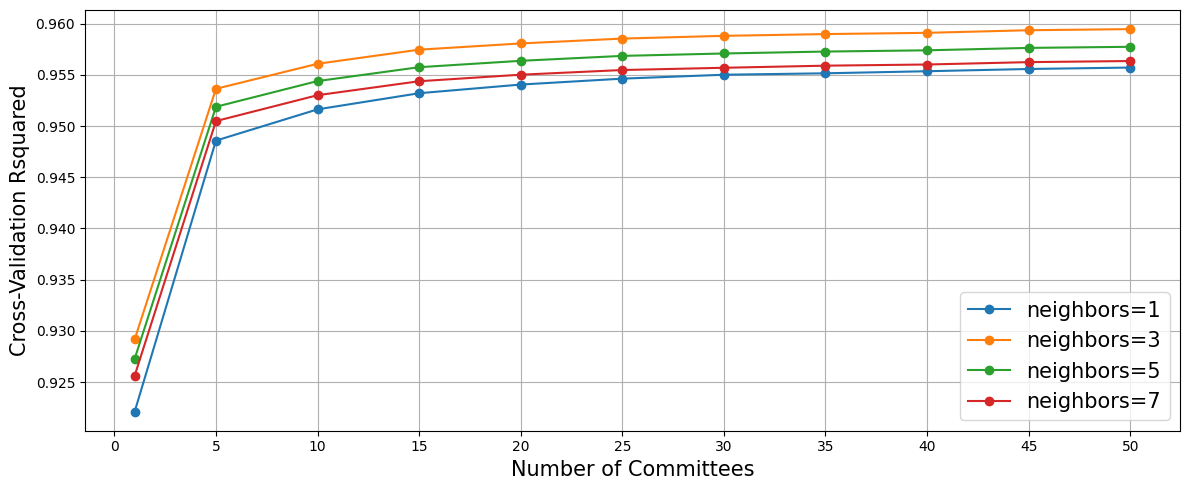

In [ ]:
cubist_local_grid_search_path = 'CUBIST.json'

# Read the JSON file
with open(cubist_local_grid_search_path, 'r') as file:
    cubist_gs = json.load(file)

# Convert the data into a DataFrame
cubist_gs_df = pd.DataFrame(cubist_gs['params'])
cubist_gs_df['y'] = cubist_gs['all_scores']

# One line per neighbors
plt.figure(figsize=(12, 5))
for neighbor in cubist_gs_df['neighbors'].unique():
    subset = cubist_gs_df[cubist_gs_df['neighbors'] == neighbor]
    plt.plot(subset['n_committees'], subset['y'], marker='o', label=f'neighbors={neighbor}')

# labels
plt.xlabel('Number of Committees', fontsize=15)
plt.ylabel("Cross-Validation Rsquared", fontsize=15)
plt.legend(title='', fontsize=15)
plt.grid(True)

# x-axis only has integer values
plt.xticks(
    range(
        cubist_gs_df['n_committees'].min() - 1,
        cubist_gs_df['n_committees'].max() + 1,
        5
    )
)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import time
# Initialize CUBIST with tuned hyperparameters
CUBIST_tuned = Cubist(n_committees=50, neighbors=3, random_state=random_seed)

# Train the tuned CUBIST on the training set
start_time = time.time()
CUBIST_tuned.fit(X_train, y_train)
end_time = time.time()
CUBIST_training_time = end_time - start_time

# Predict on the test set
CUBIST_tuned_y_pred = CUBIST_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
CUBIST_tuned_r2 = r2_score(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mse = mean_squared_error(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mae = mean_absolute_error(y_test, CUBIST_tuned_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of tuned CUBIST on test set: {CUBIST_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned CUBIST on test set: {CUBIST_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned CUBIST on test set: {CUBIST_tuned_mae:.4f}")
print(f"Training time of CUBIST: {CUBIST_training_time} seconds")



R-squared score of tuned CUBIST on test set: 0.9514
Mean Squared Error (MSE) of tuned CUBIST on test set: 19906.5154
Mean Absolute Error (MAE) of tuned CUBIST on test set: 77.1974
Training time of CUBIST: 43.12426297187805 seconds


## Multi Layer Perceptron (MLP)

The MLP model's architecture is the same as the previous experiments without feature engineering with 4 layers with different sizes. The training loss of MSE and Adam optimizer remained unchanged as well. Both ways of scaling, namely, normalization and standardization, are considered along with grid search to find the best MLP setting for our feature-engineered data.

In [ ]:
# Convert dataframe to numpy
X_train_np, X_test_np, y_train_np, y_test_np = X_train.values, X_test.values, y_train.values, y_test.values

# Model defenition
def create_mlp_model():
    model = Sequential([
        Dense(200, input_dim=X_train_s.shape[1], activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1, activation='relu')
    ])

    return model

### MLP Regression with MinMaxScaler (Normalization)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_np)
X_test_s = scaler.transform(X_test_np)

# scikit-learn API wrapper for Keras.
MLP_model = KerasRegressor(build_fn=create_mlp_model, verbose=0, loss="mse", optimizer="Adam")

# Cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Grid search
param_grid = {
    'batch_size': list(range(2, 128, 10)),
    'epochs': list(range(50, 300, 50)),
    'optimizer__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
}
grid = GridSearchCV(estimator= MLP_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='r2', verbose=4)
grid_result = grid.fit(X_train_s, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of MLP:", grid_result.best_params_)

# Best hyperparameters of MLP: 'batch size': 52, 'epochs': 150, 'learning rate': 0.005

with open('MLP.json', 'w') as file:
    json.dump(convert_to_serializable(grid_result.cv_results_), file)

The best hyperparameters of MLP (Normalization) after feature engineering are {'batch size': 52, 'epochs': 150, 'learning rate': 0.005}.

In [ ]:
# MLP with tuned huperparameters
MLP_model = create_mlp_model()
optimizer = Adam(learning_rate = 0.005)
MLP_model.compile(optimizer=optimizer, loss='mse')

# Train the tuned MLP on the training set
start_time = time.time()
MLP_model.fit(X_train_s, y_train, epochs=150, validation_split=0., batch_size=52, verbose=0)
end_time = time.time()
MLP_training_time = end_time - start_time

# Predict on the test set
MLP_tuned_y_pred = MLP_model.predict(X_test_s)

# Evaluate the model on test set (R-squared score, MSE)
MLP_tuned_r2 = r2_score(y_test, MLP_tuned_y_pred)
MLP_tuned_mse = mean_squared_error(y_test, MLP_tuned_y_pred)
MLP_tuned_mae = mean_absolute_error(y_test, MLP_tuned_y_pred)

# Display the result of the r2 socre
print("R-squared of tuned MLP on Test Set:", f"{MLP_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned MLP on test set: {MLP_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned MLP on test set: {MLP_tuned_mae:.4f}")
print(f"Training time of MLP: {MLP_training_time} seconds")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared of tuned MLP on Test Set: 0.9331
Mean Squared Error (MSE) of tuned MLP on test set: 27394.1215
Mean Absolute Error (MAE) of tuned MLP on test set: 98.9990
Training time of MLP: 58.485761404037476 seconds


### MLP Regression with StandardScaler (Standardization)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_np)
X_test_s = scaler.transform(X_test_np)

# scikit-learn API wrapper for Keras.
MLP_model = KerasRegressor(build_fn=create_mlp_model, verbose=0, loss="mse", optimizer="Adam")

# Cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Grid search
param_grid = {
    'batch_size': list(range(2, 128, 10)),
    'epochs': list(range(50, 300, 50)),
    'optimizer__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
}
grid = GridSearchCV(estimator= MLP_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='r2', verbose=4)
grid_result = grid.fit(X_train_s, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of MLP:", grid_result.best_params_)

# Best hyperparameters of MLP: 'batch size': 2, 'epochs': 250, 'learning rate': 0.001

with open('MLP.json', 'w') as file:
    json.dump(convert_to_serializable(grid_result.cv_results_), file)


The best hyperparameters of MLP (Standardization) after feature engineering are {'batch size': 52, 'batch size': 2, 'epochs': 250, 'learning rate': 0.001}.

In [ ]:
# MLP with tuned huperparameters
MLP_model = create_mlp_model()
optimizer = Adam(learning_rate = 0.001)
MLP_model.compile(optimizer=optimizer, loss='mse')

# Train the tuned MLP on the training set
start_time = time.time()
MLP_model.fit(X_train_s, y_train, epochs=250, validation_split=0., batch_size=2, verbose=0)
end_time = time.time()
MLP_training_time = end_time - start_time

# Predict on the test set
MLP_tuned_y_pred = MLP_model.predict(X_test_s)

# Evaluate the model on test set (R-squared score, MSE)
MLP_tuned_r2 = r2_score(y_test, MLP_tuned_y_pred)
MLP_tuned_mse = mean_squared_error(y_test, MLP_tuned_y_pred)
MLP_tuned_mae = mean_absolute_error(y_test, MLP_tuned_y_pred)

# Display the result of the r2 socre
print("R-squared of tuned MLP on Test Set:", f"{MLP_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned MLP on test set: {MLP_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned MLP on test set: {MLP_tuned_mae:.4f}")
print(f"Training time of MLP: {MLP_training_time} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared of tuned MLP on Test Set: 0.9544
Mean Squared Error (MSE) of tuned MLP on test set: 18679.2074
Mean Absolute Error (MAE) of tuned MLP on test set: 77.7529
Training time of MLP: 1711.5930423736572 seconds


## Ridge regression

 Both normalization and standardization are also considered for the ridge regression model.  The best hyperparameters under each scaling method are {'alpha': 0.1} and {'alpha': 1.0}, respectively. plots (for both normalization and standardization) for the performance of each hyperparameter combination are created. The summary of the performance of each of the best model can be found in their corresponding sub-section.

### Ridge Regression with MinMaxScaler (Normalization)

In [ ]:
# Define a random seed for reproducibility
random_seed = 42

#Define the independent variables (X) and depentent (target) varibale (y)
X = Bike_df_encoded_data.loc[:, Bike_df_encoded_data.columns!='Rented Bike Count']
y = Bike_df_encoded_data['Rented Bike Count']

# Normalize the independent variables (scaling)
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

#Split the dataste into a 75% training set and a 25% test set
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_scale, y, test_size= 0.25, random_state= random_seed)

In [ ]:
# Initialize the Ridge Regression model
model = Ridge(random_state=random_seed)

# Define the parameter grid to search over
grid = dict()
grid['alpha'] = np.logspace(-4, 5, 10) # Logarithmically spaced alpha values for Ridge

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train_scale, y_train_scale)

# Summarize the best score and configuration
print("Best hyperparameters of ridge regression:", grid_result.best_params_)

ridge_grid_search_path = 'ridge_normalization.json'
with open(ridge_grid_search_path, 'w') as file:
    json.dump(convert_to_serializable(grid_result.cv_results_), file)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters of ridge regression: {'alpha': 0.1}


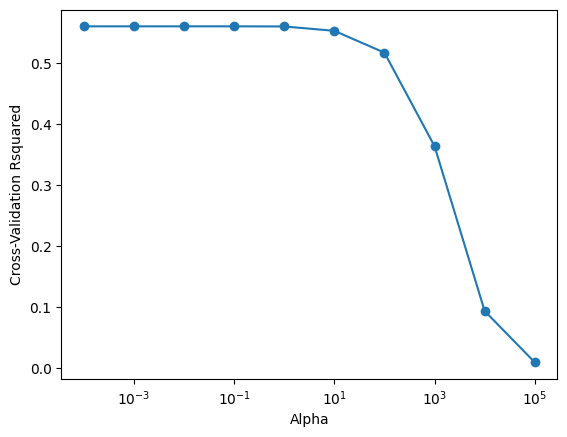

In [ ]:
# Open and read the JSON file
with open(ridge_grid_search_path, 'r') as file:
    ridge_gs = json.load(file)

x = []
y = []
for param, mean_score in zip(ridge_gs['params'], ridge_gs['mean_test_score']):
    x.append(param['alpha'])
    y.append(mean_score)

plt.plot(x, y, marker='o')

# Set the x-axis to a log scale to make it easier to see smaller alpha values
plt.xscale('log')

# labels
plt.xlabel("Alpha")
plt.ylabel("Cross-Validation Rsquared")

# Show the graph
plt.show()

In [ ]:
# Initialize Ridge Regression model with the best hyperparameter (alpha=1), which is the default hyperparamter
ridge_reg = Ridge(alpha=0.1, random_state=random_seed)

# Train the model on the training set
start_time = time.time()
ridge_reg.fit(X_train_scale, y_train_scale)
end_time = time.time()
ridge_training_time = end_time - start_time

# Predict on the test set
ridge_reg_y_pred = ridge_reg.predict(X_test_scale)

# Evaluate the model on test set uning R2 score
ridge_reg_r2 = r2_score(y_test_scale, ridge_reg_y_pred)
ridge_reg_mse = mean_squared_error(y_test_scale, ridge_reg_y_pred)
ridge_reg_mae = mean_absolute_error(y_test_scale, ridge_reg_y_pred)

print("R-squared of ridge regression model (after scaling) on Test Set:", ridge_reg_r2)
print(f"Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: {ridge_reg_mse:.4f}")
print(f"Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: {ridge_reg_mae:.4f}")
print(f"Training time of ridge regression (after scaling): {ridge_training_time} seconds")




R-squared of ridge regression model (after scaling) on Test Set: 0.538515507078769
Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: 188839.9082
Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: 327.0177
Training time of ridge regression (after scaling): 0.013275623321533203 seconds


### Ridge Regression with StandardScaler (Standardization)

In [ ]:
# Define a random seed for reproducibility
random_seed = 42

#Define the independent variables (X) and depentent (target) varibale (y)
X = Bike_df_encoded_data.loc[:, Bike_df_encoded_data.columns!='Rented Bike Count']
y = Bike_df_encoded_data['Rented Bike Count']

#standardize the independent variables (scaling)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

#Split the dataste into a 75% training set and a 25% test set
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_scale, y, test_size= 0.25, random_state= random_seed)

In [ ]:
# Initialize the Ridge Regression model
model = Ridge(random_state=random_seed)

# Define the parameter grid to search over
grid = dict()
grid['alpha'] = np.logspace(-4, 5, 10) # Logarithmically spaced alpha values for Ridge

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train_scale, y_train_scale)

# Summarize the best score and configuration
print("Best hyperparameters of ridge regression:", grid_result.best_params_)

ridge_grid_search_path = 'ridge_standardization.json'
with open(ridge_grid_search_path, 'w') as file:
    json.dump(convert_to_serializable(grid_result.cv_results_), file)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Best hyperparameters of ridge regression: {'alpha': 1.0}


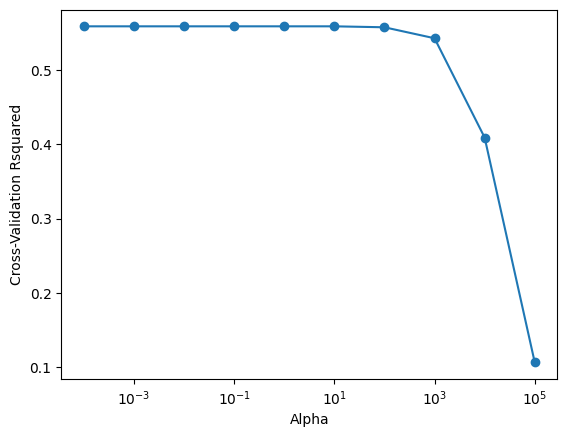

In [ ]:
# Open and read the JSON file
with open(ridge_grid_search_path, 'r') as file:
    ridge_gs = json.load(file)

x = []
y = []
for param, mean_score in zip(ridge_gs['params'], ridge_gs['mean_test_score']):
    x.append(param['alpha'])
    y.append(mean_score)

plt.plot(x, y, marker='o')

# Set the x-axis to a log scale to make it easier to see smaller alpha values
plt.xscale('log')

# labels
plt.xlabel("Alpha")
plt.ylabel("Cross-Validation Rsquared")

# Show the graph
plt.show()

In [ ]:
# Initialize Ridge Regression model with the best hyperparameter (alpha=1), which is the default hyperparamter
ridge_reg = Ridge(alpha=0.1, random_state=random_seed)

# Train the model on the training set
start_time = time.time()
ridge_reg.fit(X_train_scale, y_train_scale)
end_time = time.time()
ridge_training_time = end_time - start_time

# Predict on the test set
ridge_reg_y_pred = ridge_reg.predict(X_test_scale)

# Evaluate the model on test set uning R2 score
ridge_reg_r2 = r2_score(y_test_scale, ridge_reg_y_pred)
ridge_reg_mse = mean_squared_error(y_test_scale, ridge_reg_y_pred)
ridge_reg_mae = mean_absolute_error(y_test_scale, ridge_reg_y_pred)

print("R-squared of ridge regression model (after scaling) on Test Set:", ridge_reg_r2)
print(f"Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: {ridge_reg_mse:.4f}")
print(f"Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: {ridge_reg_mae:.4f}")
print(f"Training time of ridge regression (after scaling): {ridge_training_time} seconds")




R-squared of ridge regression model (after scaling) on Test Set: 0.5381521914570692
Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: 188988.5773
Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: 327.0669
Training time of ridge regression (after scaling): 0.03571915626525879 seconds


## Summary of the Performance of the Four Regression Models

With the exception of the Ridge regression model all other models saw an improvement in performance after feature engineering with all of their MAE, and MSE decreasing indicating less difference between the predictions and target values. These results support the claim that feature engineering can reveal stable and consistent temporal patterns that are useful for modeling bike usage in Seoul.

Out of the four models, MLP with standardization has the strongest performance with the highest R2 and the lowest MSE and MAE:

*   MLP (standardization): R2 of 95.4%, MSE of 18679.2074, and MAE of 77.7529
*   MLP (normalization): R2 of 93.3%, MSE of 27394.1, and MAE of 99
*   CUBIST: R2 of 95.1%, MSE of 19906.5, and MAE of 77.2
*   GBM: R2 of 94.7%, MSE of 21741.7, and MAE of 80.9
*   Ridge Regression (normalization): R2 of 53.9%, MSE of 188839.9, and MAE of 297.3
*   Ridge Regression (standardization): R2 of 53.8%, MSE of 188988.5, and MAE of 327.1



## Conclusion

The CUBIST model (lowest MAE) and MLP model (highest R-squared and lowest MSE) outperform the other models. The decision on which one is a better model depends on the goals of the bikeshare operators. Since the MAE is lower in the CUBIST model, it is preferred if bikeshare operators want to minimize the absolute differences between the predictions and the actual bike demand. On the other hand, if the objective is to have a model that can better explain the patterns and trends of the rental bike demand, and avoid large errors in predictions for rental bike demand, MLP model is preferred as it has a higher R-squares and a lower MSE.

Due to the limitation of the dataset, which doesn't have any spatial features, the analysis is unable to consider the location specific variations in renting bikes. Future work could include the prediction of rental bike demand based on both temporal and spatial factors for the district level, instead of the whole city of Seoul. Considering the spatial data, such as travel distance to the bike stations or popular destinations, could gain deeper insights into customers' behaviors and improve the prediction of rented bike count, ensuring sufficient supply of rental bikes across different stations to avoid user inconvenience.



